In [3]:
import datetime as dt
import numpy as np
import os
import xarray as xr
import utils
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12,5
import matplotlib.pyplot as plt
from matplotlib import dates as mpldates
import glob
import met_utils as mu
import pandas as pd
from utils import read_tdump
from itertools import cycle
import lagrangian_case as lc
import inversion_heights as inv_tools
from scipy.stats import linregress
old_settings = np.seterr(invalid='ignore')  #seterr to known value
%load_ext autoreload
%autoreload 2
from scipy import integrate

from matplotlib import gridspec, rc

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)


In [127]:
ALC_RF06 = lc.AircraftCase("ALC_RF06BC-RF07A")
ALC_RF10 = lc.AircraftCase("ALC_RF10A-RF11DE")

In [35]:
ALC_RF10.add_ERA_data()

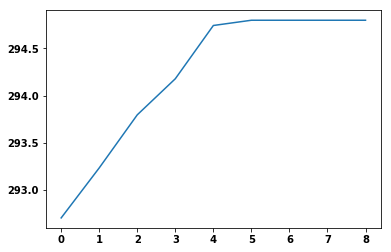

In [37]:
plt.plot(ALC_RF10.outbound_Flight_Piece.ERA_data['ERA_sst'])

In [5]:
traj_RF06 = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf06_all_traj_2.6.nc')

traj_RF10 = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf10_all_traj_6.0.nc')
traj_RF10_2 = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf10_all_traj_5.5.nc')

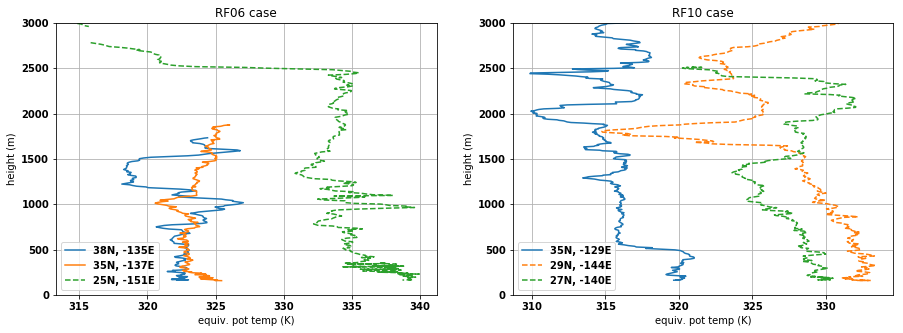

In [11]:
# plotting soundings at start/end of flights
def add_fp_to_plot(ax, fp, ls):
    for seq in fp.sequences:
        prof = fp.flight_data.where(np.logical_and(fp.flight_data.sequence == seq, fp.flight_data.leg == 'd'), drop=True)
        inv_dec = inv_tools.calc_decoupling_and_zi_from_flight_data(prof)
        label = "{:0.0f}N, {:0.0f}E".format(inv_dec['lat'], inv_dec['lon'])
        l = ax.plot(prof.THETAE, prof.GGALT, label=label, ls=ls)
        ax.set_xlabel("equiv. pot temp (K)")
        ax.set_ylabel("height (m)")
#         ax.plot(inv_dec['Heff'][s'T_bot'], inv_dec['Heff']['z_bot'], 'x', ms=10, mew=5, c=l[0].get_c())

fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(15,5))
ax.set_title("RF06 case")
add_fp_to_plot(ax, ALC_RF06.outbound_Flight_Piece, '-')
add_fp_to_plot(ax, ALC_RF06.return_Flight_Piece, '--')

ax2.set_title("RF10 case")
add_fp_to_plot(ax2, ALC_RF10.outbound_Flight_Piece, ls='-')
add_fp_to_plot(ax2, ALC_RF10.return_Flight_Piece, ls='--')

for i in [ax, ax2]:
    i.grid(True)
    i.set_ylim(0, 3000)
#     i.set_xlim(280, 295)
    i.legend()

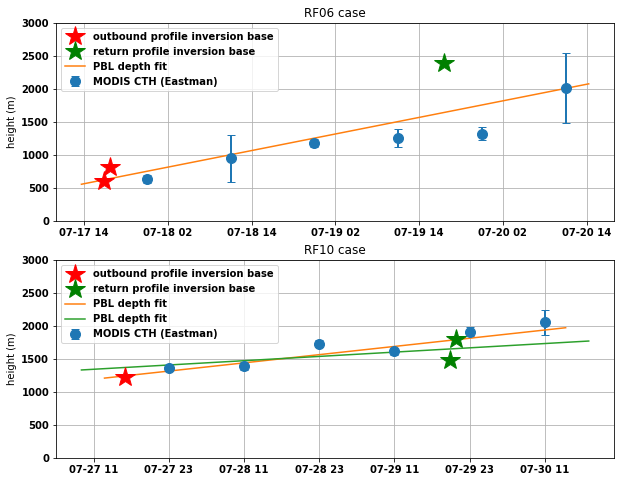

In [13]:
#plotting inversion hgt + MODIS CTH along trajectories

def add_inv_to_plot(ax, fp, **plargs):
    for seq in fp.sequences:
        prof = fp.flight_data.where(np.logical_and(fp.flight_data.sequence == seq, fp.flight_data.leg == 'd'), drop=True)
        inv_dec = inv_tools.calc_decoupling_and_zi_from_flight_data(prof)
        label = "{:0.0f}N, {:0.0f}E".format(inv_dec['lat'], inv_dec['lon'])
        ax.plot(utils.as_datetime(inv_dec['time']), inv_dec['Heff']['z_bot'], '*', ms=20, **plargs, zorder=10)
        if 'label' in plargs.keys():
            del plargs['label']

def add_fit_to_plot(ax, ALC, traj, **plargs):
    xs, ys = [], []
    xs.extend(traj.time.values[~np.isnan(traj.MODIS_CTH.values)])
    ys.extend(traj.MODIS_CTH.values[~np.isnan(traj.MODIS_CTH.values)]*1000)
    for fp in [ALC.outbound_Flight_Piece, ALC.return_Flight_Piece]:
        for seq in fp.sequences:
            prof = fp.flight_data.where(np.logical_and(fp.flight_data.sequence == seq, fp.flight_data.leg == 'd'), drop=True)
            inv_dec = inv_tools.calc_decoupling_and_zi_from_flight_data(prof)
            xs.append(inv_dec['time'])
            ys.append(inv_dec['Heff']['z_bot'])
    
    xs_num = [mpldates.date2num(i) for i in utils.as_datetime(xs)]
    m, b, r_value, p_value, stderr = linregress(xs_num, ys)
    lx = np.linspace(*ax.get_xlim(), 10)
    ly = m*lx + b
    label= "d_inv_dt = {:0.2f} mm/s".format(m/86.4)
    label='PBL depth fit'
    ax.plot(lx, ly, label=label, **plargs)
        
fig, [ax, ax2] = plt.subplots(nrows=2, figsize=(10,8))
ax.set_title("RF06 case")
add_inv_to_plot(ax, ALC_RF06.outbound_Flight_Piece, color='r', label='outbound profile inversion base')
add_inv_to_plot(ax, ALC_RF06.return_Flight_Piece, color='g', label='return profile inversion base')
ax.errorbar(x=traj_RF06.time.values, y=traj_RF06.MODIS_CTH*1000, yerr=traj_RF06.MODIS_CTH_std*1000, 
            marker='.', ms=20, ls='', lw=2, capsize=4, label='MODIS CTH (Eastman)')
add_fit_to_plot(ax, ALC_RF06, traj_RF06)

ax2.set_title("RF10 case")
add_inv_to_plot(ax2, ALC_RF10.outbound_Flight_Piece, color='r', label='outbound profile inversion base')
add_inv_to_plot(ax2, ALC_RF10.return_Flight_Piece, color='g', label='return profile inversion base')
ax2.errorbar(x=traj_RF10.time.values, y=traj_RF10.MODIS_CTH*1000, yerr=traj_RF10.MODIS_CTH_std*1000, 
             marker='.', ms=20, ls='', lw=2, capsize=4, label='MODIS CTH (Eastman)')
add_fit_to_plot(ax2, ALC_RF10, traj_RF10)
add_fit_to_plot(ax2, ALC_RF10, traj_RF10_2)

for i in [ax, ax2]:
    i.grid(True)
    i.legend(loc='upper left')
    i.set_ylim(0, 3000)
    i.set_ylabel("height (m)")


/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:191: RuntimeWarning: Mean of empty slice
  qt_sml = np.nanmean(qt[l_i])
/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:192: RuntimeWarning: Mean of empty slice
  qt_bzi = np.nanmean(qt[u_i])
/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:193: RuntimeWarning: Mean of empty slice
  qt_uzi = np.nanmean(qt[l_ft])


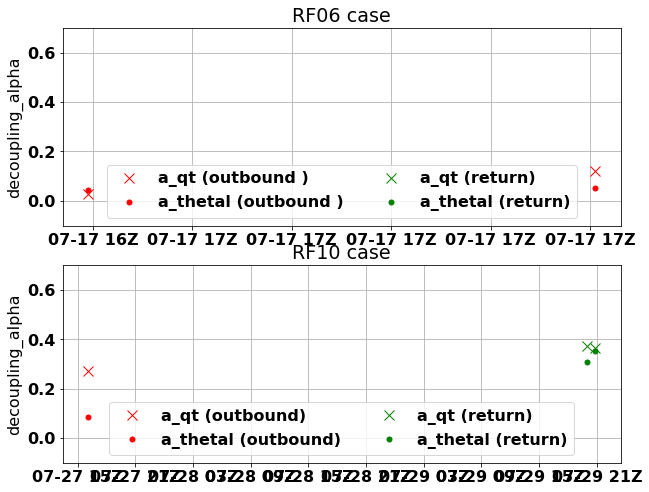

In [28]:
# plotting decoupling estimates

def add_dec_to_plot(ax, fp, **plargs):
    lp = plargs.setdefault('label', '')
    labels = ["{} ({})".format(i, lp) for i in ['a_qt', 'a_thetae', 'a_thetal']]
    if 'label' in plargs.keys():
        del plargs['label']
    for seq in fp.sequences:
        prof = fp.flight_data.where(np.logical_and(fp.flight_data.sequence == seq, fp.flight_data.leg == 'd'), drop=True)
        inv_dec = inv_tools.calc_decoupling_and_zi_from_flight_data(prof)
        #label = "{:0.0f}N, {:0.0f}E".format(inv_dec['lat'], inv_dec['lon'])
        ax.plot(utils.as_datetime(inv_dec['time']), inv_dec['alpha_qt'], 'x', ms=10, label=labels[0], **plargs)
#         ax.plot(utils.as_datetime(inv_dec['time']), inv_dec['alpha_thetae'], 's', ms=10, label=labels[1], **plargs)
        ax.plot(utils.as_datetime(inv_dec['time']), inv_dec['alpha_thetal'], '.', ms=10, label=labels[2], **plargs)
        labels = ['', '', '']

            
fig, [ax, ax2] = plt.subplots(nrows=2, figsize=(10,8))
ax.set_title("RF06 case")
add_dec_to_plot(ax, ALC_RF06.outbound_Flight_Piece, color='r', label='outbound ')
add_dec_to_plot(ax, ALC_RF06.return_Flight_Piece, color='g', label='return')
ax2.set_title("RF10 case")
add_dec_to_plot(ax2, ALC_RF10.outbound_Flight_Piece, color='r', label='outbound')
add_dec_to_plot(ax2, ALC_RF10.return_Flight_Piece, color='g', label='return')
for i in [ax, ax2]:
    i.set_ylabel("decoupling_alpha")
    i.set_ylim(-0.1, 0.7)
    i.grid(True)
    i.legend(ncol=2, loc='lower center')


/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:191: RuntimeWarning: Mean of empty slice
  qt_sml = np.nanmean(qt[l_i])
/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:192: RuntimeWarning: Mean of empty slice
  qt_bzi = np.nanmean(qt[u_i])
/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:193: RuntimeWarning: Mean of empty slice
  qt_uzi = np.nanmean(qt[l_ft])
/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:191: RuntimeWarning: Mean of empty slice
  qt_sml = np.nanmean(qt[l_i])
/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:192: RuntimeWarning: Mean of empty slice
  qt_bzi = np.nanmean(qt[u_i])
/home/disk/p/jkcm/Code/Lagrangian_CSET/inversion_heights.py:193: RuntimeWarning: Mean of empty slice
  qt_uzi = np.nanmean(qt[l_ft])


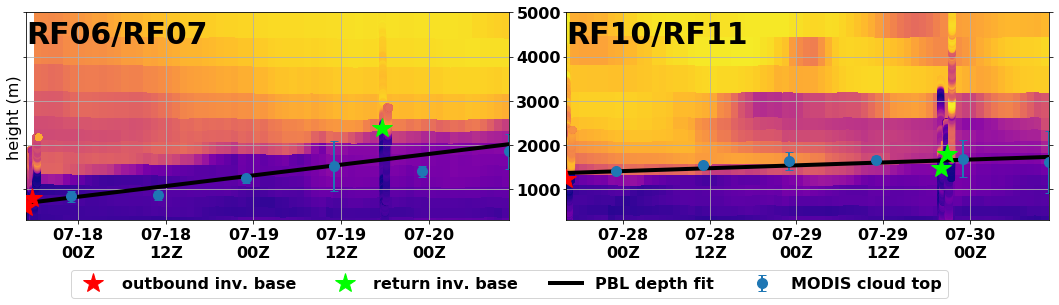

In [70]:
fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(15,4), sharey=True)
# ax.set_title("RF06 case")
ax.text(0, 0.85, "RF06/RF07", horizontalalignment='left', transform=ax.transAxes, fontdict = {'size': 30})

X = np.broadcast_to(traj_RF06.time.values[:,None], traj_RF06.ERA_r.values.shape)
pc = ax.pcolor(X, traj_RF06.ERA_z.values/9.81, traj_RF06.ERA_r.values, cmap='plasma_r', vmin=0, vmax=100)
sc = ax.scatter(ALC_RF06.return_flight_data.Time.values, ALC_RF06.return_flight_data.GGALT.values,
            c=ALC_RF06.return_flight_data.RHUM.values, cmap='plasma_r', vmin=0, vmax=100)
sc2 = ax.scatter(ALC_RF06.outbound_flight_data.Time.values, ALC_RF06.outbound_flight_data.GGALT.values,
            c=ALC_RF06.outbound_flight_data.RHUM.values, cmap='plasma_r', vmin=0, vmax=100)
add_inv_to_plot(ax, ALC_RF06.outbound_Flight_Piece, color='red', label='outbound inv. base')
add_inv_to_plot(ax, ALC_RF06.return_Flight_Piece, color='lime', label='return inv. base')
ax.errorbar(x=traj_RF06.time.values, y=traj_RF06.MODIS_CTH*1000, yerr=traj_RF06.MODIS_CTH_std*1000, 
            marker='.', ms=20, ls='', lw=2, capsize=4, label='MODIS cloud top')
add_fit_to_plot(ax, ALC_RF06, traj_RF06, c='k', lw=4)

# plt.colorbar(pc, ax=ax, label='ERA RH')


# ax2.set_title("RF10 case")
ax2.text(0, 0.85, "RF10/RF11", horizontalalignment='left', transform=ax2.transAxes, fontdict = {'size': 30})

X = np.broadcast_to(traj_RF10.time.values[:,None], traj_RF10.ERA_r.values.shape)
pc = ax2.pcolor(X, traj_RF10.ERA_z.values/9.81, traj_RF10.ERA_r.values, cmap='plasma_r', vmin=0, vmax=100)
sc = ax2.scatter(ALC_RF10.return_flight_data.Time.values, ALC_RF10.return_flight_data.GGALT.values,
            c=ALC_RF10.return_flight_data.RHUM.values, cmap='plasma_r', vmin=0, vmax=100)
sc2 = ax2.scatter(ALC_RF10.outbound_flight_data.Time.values, ALC_RF10.outbound_flight_data.GGALT.values,
            c=ALC_RF10.outbound_flight_data.RHUM.values, cmap='plasma_r', vmin=0, vmax=100)
add_inv_to_plot(ax2, ALC_RF10.outbound_Flight_Piece, color='red', label='outbound inversion base')
add_inv_to_plot(ax2, ALC_RF10.return_Flight_Piece, color='lime', label='return inversion base')
ax2.errorbar(x=traj_RF10.time.values, y=traj_RF10.MODIS_CTH*1000, yerr=traj_RF10.MODIS_CTH_std*1000, 
             marker='.', ms=20, ls='', lw=2, capsize=4, label='MODIS cloud top')
add_fit_to_plot(ax2, ALC_RF10, traj_RF10, c='k', lw=4)
# plt.colorbar(pc, ax=ax2, label='ERA RH')


for i in [ax, ax2]:
    i.grid(True)
    i.set_ylim(300, 5000)
    i.set_ylabel("height (m)")
#     plt.setp(i.get_xticklabels(), rotation=30)
    myFmt = mpldates.DateFormatter('%m-%d\n%HZ')
    i.xaxis.set_major_formatter(myFmt)
    xlocator = mpldates.HourLocator(byhour=[0, 12], interval = 1)
    i.xaxis.set_major_locator(xlocator)
    
# ax.legend(loc=9, bbox_to_anchor=(1, -0.2), ncol=4)
ax.yaxis.set_label_position("left")
ax.tick_params(axis='y', left=True, right=True, labelleft=False, labelright=True)
ax2.yaxis.label.set_visible(False)
# ax.yaxis.label.set_visible(False)

ax2.tick_params(axis='y', left=True, right=True, labelleft=False, labelright=False)
plt.tight_layout(w_pad=0.1)
ax.legend(loc=9, bbox_to_anchor=(1, -0.2), ncol=4)



fig.savefig(os.path.join(utils.plot_dir, 'inv_height_plt.png'), dpi=300, bbox_inches='tight')



In [72]:
#Loading sou

i = np.argwhere(~np.isnan(traj_RF06.MODIS_CTH.values)).flatten()[2]
raw = xr.open_dataset(r"/home/disk/eos4/jkcm/Data/CSET/ERA5/ERA5.pres.NEP.2015-07-18.nc")
raw_z = raw['z'].sel(longitude=traj_RF06.lon[i].values%360,
                 latitude=traj_RF06.lat[i].values,
                 time=traj_RF06.time[i].values,
                 method='nearest')/9.81
raw_r = raw['r'].sel(longitude=traj_RF06.lon[i].values%360,
                 latitude=traj_RF06.lat[i].values,
                 time=traj_RF06.time[i].values,
                 method='nearest')
MERRA = xr.open_dataset(r'/home/disk/eos4/jkcm/Data/CSET/MERRA/pressure/MERRA2_400.inst3_3d_asm_Np.20150718.SUB.nc')
MERRA_z = MERRA['H'].sel(lon=traj_RF06.lon[i].values,
                         lat=traj_RF06.lat[i].values,
                         time=traj_RF06.time[i].values,
                         method='nearest')
MERRA_r = MERRA['RH'].sel(lon=traj_RF06.lon[i].values,
                         lat=traj_RF06.lat[i].values,
                         time=traj_RF06.time[i].values,
                         method='nearest')

(0, 4)

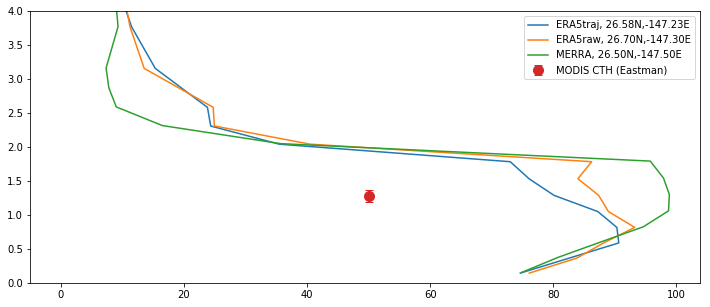

In [92]:
plt.plot(traj_RF06.ERA_r[i,:].values, traj_RF06.ERA_z[i,:].values/9.81/1000, 
         label='ERA5traj, {:0.2f}N,{:0.2f}E'.format(traj_RF06.lat[i].values, traj_RF06.lon[i].values))
plt.plot(raw_r, raw_z/1000, 
         label='ERA5raw, {:0.2f}N,{:0.2f}E'.format(raw_r.latitude.values, raw_r.longitude.values-360))
plt.plot(MERRA_r*100, MERRA_z/1000, 
         label='MERRA, {:0.2f}N,{:0.2f}E'.format(MERRA_r.lat.values, MERRA_z.lon.values))
plt.errorbar(x=50, y=traj_RF06.MODIS_CTH[i].values, yerr=traj_RF06.MODIS_CTH_std[i].values, 
             marker='.', ms=20, ls='', lw=2, capsize=4, label='MODIS CTH (Eastman)')
plt.legend()
plt.ylim(0,4)

In [20]:
ALC_cases = {}
for key, case in lc.all_cases.items():
#     if key not in [6, 10]:
#         continue
    print(key)
    ALC = lc.AircraftCase(case['ALC_name'])
    ALC.add_ERA_data()
    ALC_cases[key] = ALC

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [183]:
def plot_profile(profile, name):
    
    zi = profile['dec']
    dec = profile['dec']
    theta = profile['sounding']['THETA']
    z = profile['sounding']['GGALT']
    qv = profile['sounding']['QV']
    qt = qv + np.nan_to_num(profile['sounding']['QL'], 0)
    rh = profile['sounding']['RHUM']
    p = profile['sounding']['PSXC']
    t = profile['sounding']['ATX']
    thetae = profile['sounding']['THETAE']
    thetal = profile['sounding']['THETAL']

    
    q_sat = mu.qvs_from_p_T(p=p*100, T=t)
    sat_mse = mu.moist_static_energy(t=t, z=profile['sounding']['GGALT'], q=q_sat)/1000
    mse = mu.moist_static_energy(t=t, z=z, q=qv/1000)/1000
    
    h = mu.smooth(sat_mse, window_len=31)
    dhdz = np.gradient(h, z)
    dhdz[np.abs(dhdz)>.1] = np.nan
#     cust_inv = mu.inv_layer_from_sounding(profile['sounding'])

    
    gamma_moist = mu.get_moist_adiabatic_lapse_rate(T=t, p=p)*1000
    gamma = -np.gradient(mu.smooth(t, window_len=31), z)*1000
 
    
    fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(ncols=6, sharey=True, figsize=(16,5))
    ax1.plot(t, z)
    ax1.set_ylim(0,4000)
    ax1.set_xlabel('temp (K)')
    ax1.axvline(dec['t_below_inv'], label='t_below_inv', c='r')
    ax1.axvline(dec['t_above_inv'], label='t_above_inv', c='r')

#     ax1.plot(theta, z)
#     ax1.set_ylim(0,4000)
#     ax1.set_xlabel('pot temp (K)')
#     ax1.axvline(theta[dec['i_bot']], c='r')
#     ax1.axvline(theta[dec['i_bot']]+dec['d_t_inv'], c='r')
# #     ax1.axvline(thetae['t_below_inv'], label='t_below_inv', c='r')
# #     ax1.axvline(dec['t_above_inv'], label='t_above_inv', c='r')
#     ax1.set_xlim(285, 310)


    d_t = dec['d_t_inv']
    d_thetal = thetal[dec['i_top']] - thetal[dec['i_bot']]
    print(d_t, d_thetal)
    

    ax2.plot(qt, z)
    ax2.axhline(zi['z_bot'], label='inv base')
    ax2.axhline(zi['z_top'], label='inv top')
    ax2.set_xlabel("qt (g/kg)")
    ax2.axvline(dec['q_below_inv'], label='q_below_inv', c='r')
    ax2.axvline(dec['q_above_inv'], label='q_above_inv', c='r')
    
    
    ax3.plot(rh, z)
    ax3.set_xlabel('RH (%)')
    ax3.axvline(80, label='80')
#     ax3.axvline(60, label='50')

    ax4.plot(mse, z)
    ax4.set_xlabel("MSE(kJ/kg)")
    ax4.plot(sat_mse, z, c='r', label='sat_mse')

    ax5.plot(dhdz[5:-5], z[5:-5])
    ax5.set_xlabel("dh*/dz (kJ/kg/M)")

    ax6.plot(gamma, z, label='lapse rate')
    ax6.plot(gamma_moist, z, label='moist adiabatic lapse rate')
    ax6.set_xlabel('lapse rate (K/km)')
    ax6.set_xlim(-10, 10)
    
    
    if not np.isnan(dec['i_mid']):   
        for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
            ax.axhline(z[dec['i_mid']], c='g')
            ax.axhline(z[dec['i_bot']], c='g')
            ax.axhline(z[dec['i_top']], c='g')
    
    else:
        ax3.text(0.2, 0.8, 'NO INV')
    

    
#     ax1.axhline(cust_inv['z_mid'], c='r')
#     ax2.axhline(cust_inv['z_mid'], c='r')
#     ax3.axhline(cust_inv['z_mid'], c='r')


#     ax2.axvline(dec['q_below_inv'], label='q_below_inv', c='r')
#     ax2.axvline(dec['q_above_inv'], label='q_above_inv', c='r')
    
    
    
    fig.suptitle(name)
    return fig

In [57]:
        sondes = []
        sonde_files = glob.glob(os.path.join(utils.dropsonde_dir, "*.nc"))
#         for f in sonde_files:
#             sondes.append(get_data_from_dropsonde(f))

In [65]:
AVAPS_dates = [dt.datetime.strptime(os.path.basename(i), 'D%Y%m%d_%H%M%S_PQC.nc') for i in sonde_files]

In [ ]:
for num, case in ALC_cases.items():
    for fp in [case.outbound_Flight_Piece, case.return_Flight_Piece]:
            profiles = fp.get_profiles()
                


6.413202814780843 9.417206
7.041277184626141 9.259857
6.749301254749756 nan
4.482873425604252 6.8000793
4.053116065487165 6.002716
6.052027373381268 8.285065
2.471109179109086 3.7862854
1.6615691613239143 3.4714966
4.1033800186825715 7.2744446
2.0033190261474125 3.784729
1.7238034821648036 4.137909
1.2135932229718256 2.3867798
nan 21.905853
5.728621046416527 10.345398
3.5740290979448157 7.189392
3.8749150798152208 8.142151
2.698717704689663 4.8401794
4.1449461377497325 6.3070374
6.186297817713501 9.811676
3.532226171442024 4.9020386
4.441043101815758 6.400299
1.1059899770152295 nan
4.794504869113862 7.256592
2.9979984869068126 4.568451
3.252704697421073 5.115082
3.9223591997619867 7.4224854
6.898376358272594 9.797638
1.0906435484263441 2.1279907
2.3827954842785246 4.8009033
3.4204384579521605 5.823578
4.13330554706485 6.636566
2.7235580532284143 3.845337
5.250712162065956 7.1297913
3.069791697179816 4.837982
2.0905446150281413 3.8111267
7.111204525923069 10.202362
7.911222568839657 10.

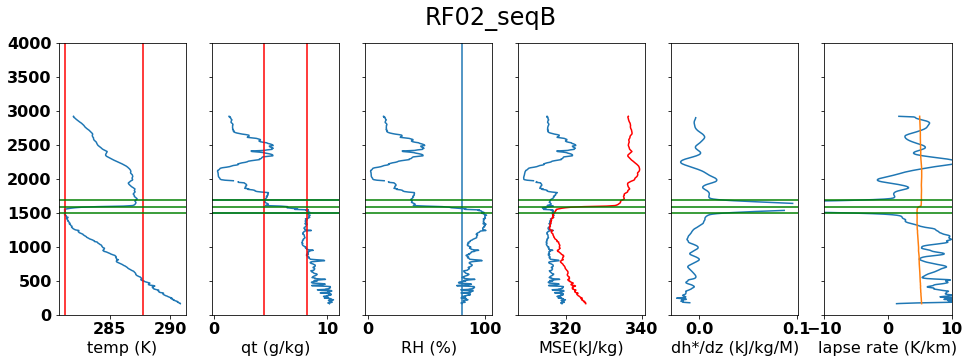

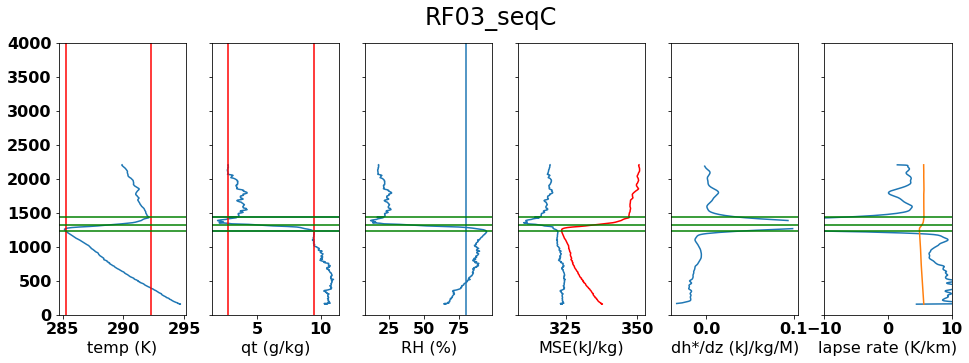

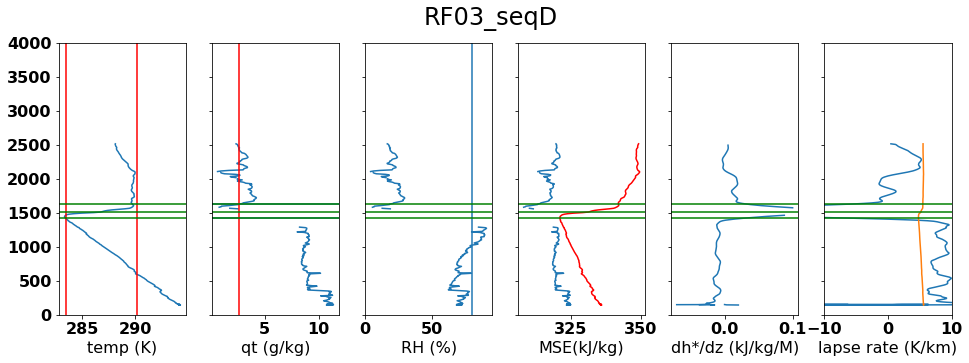

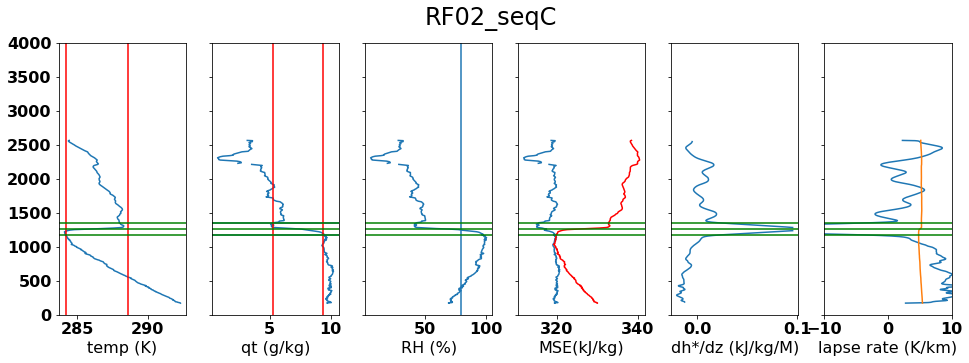

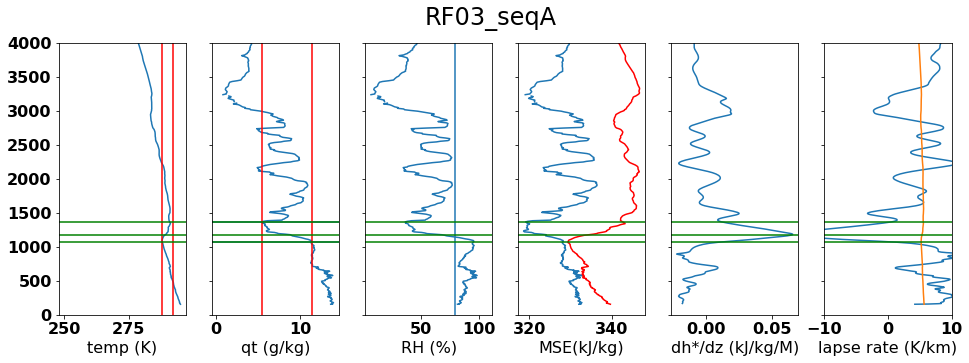

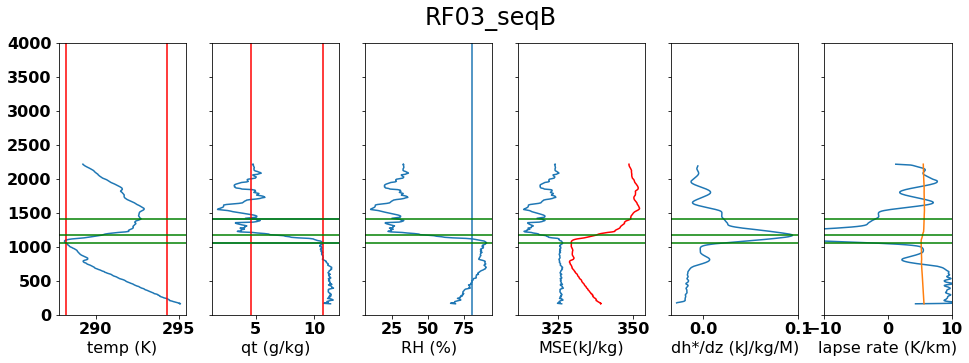

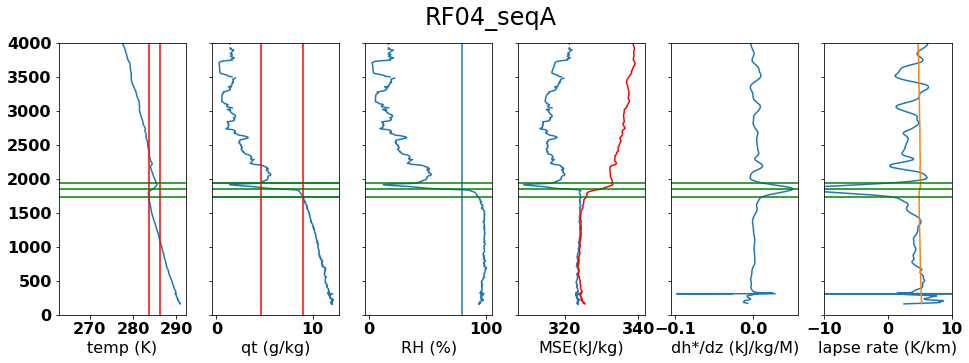

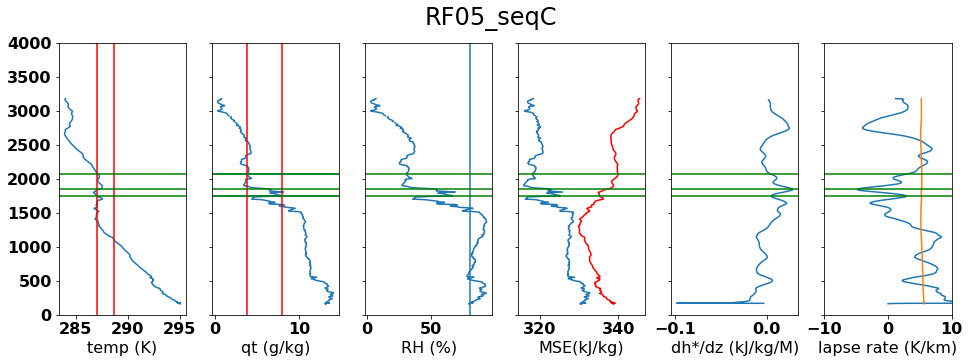

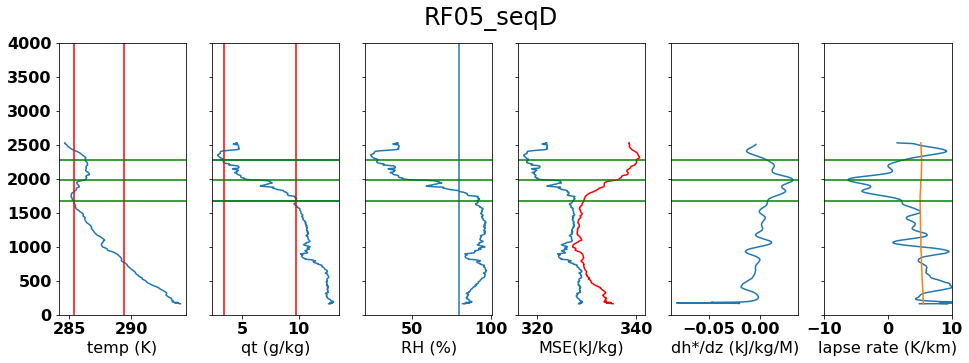

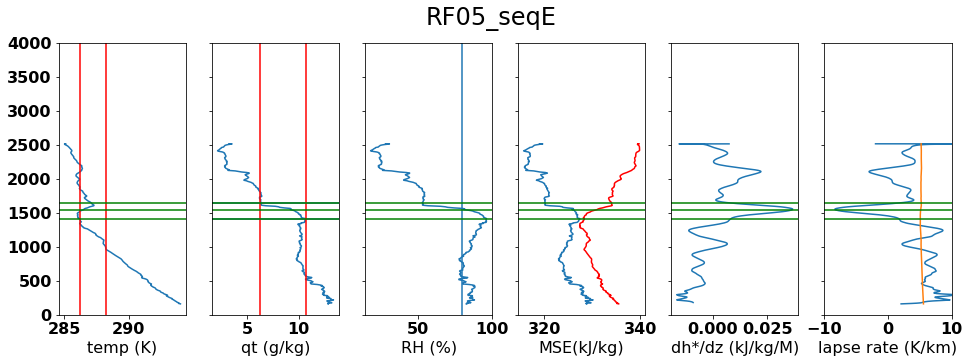

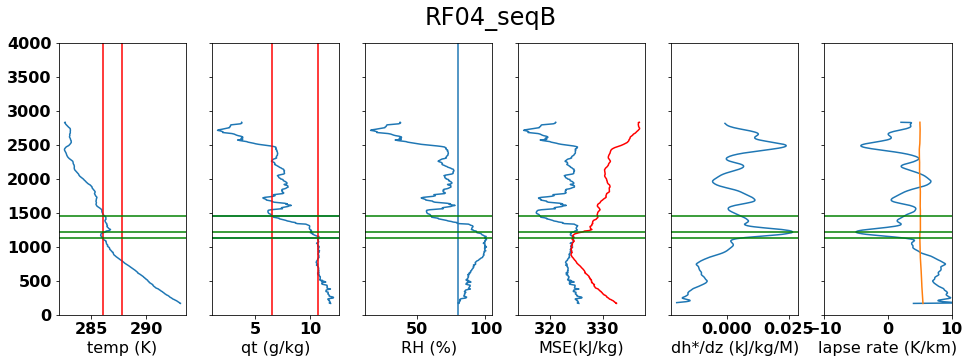

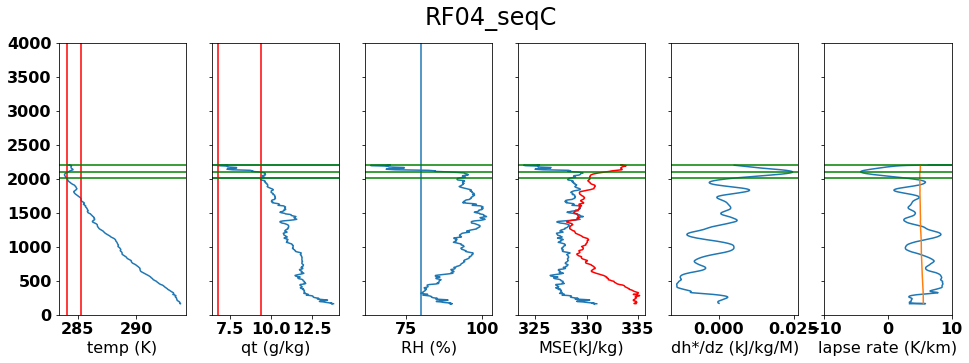

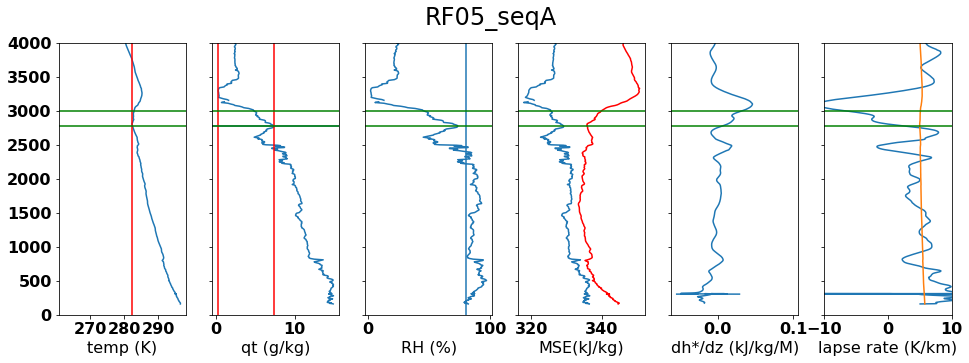

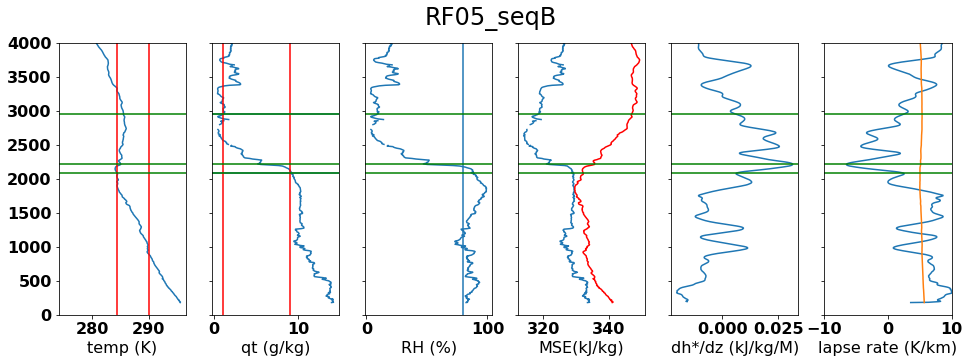

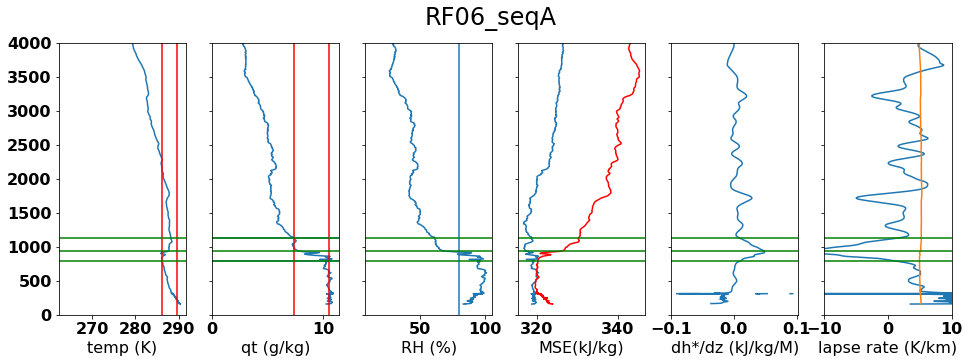

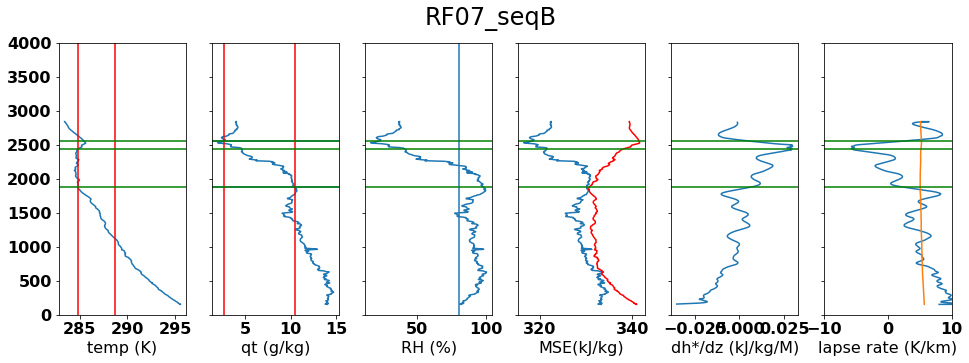

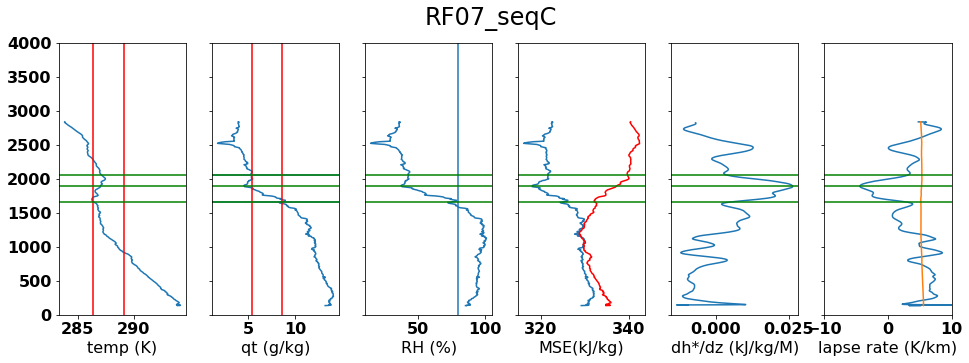

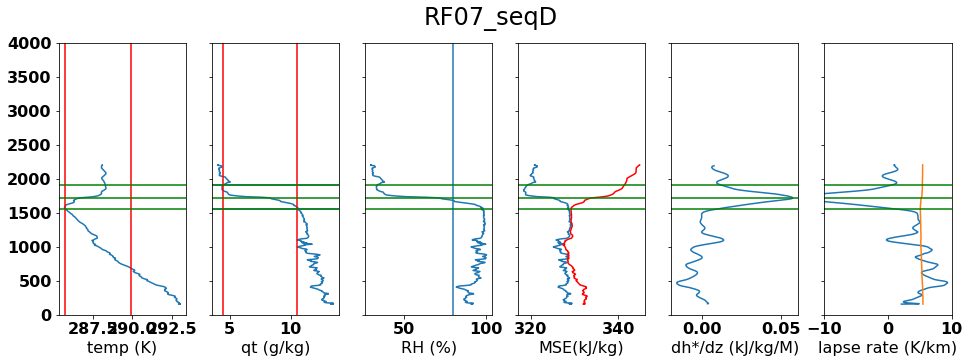

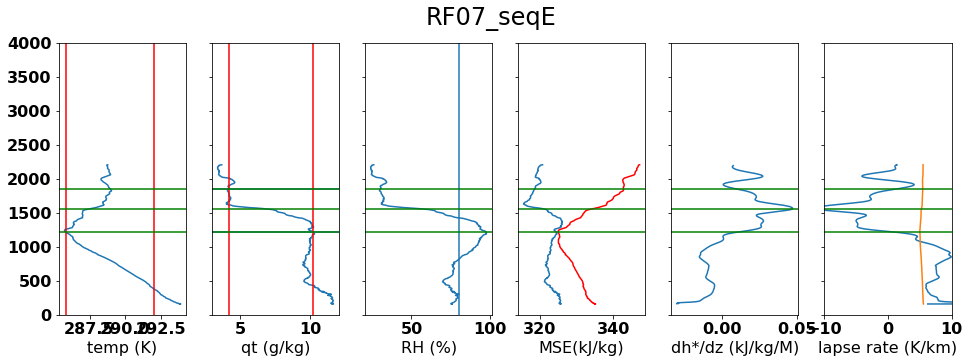

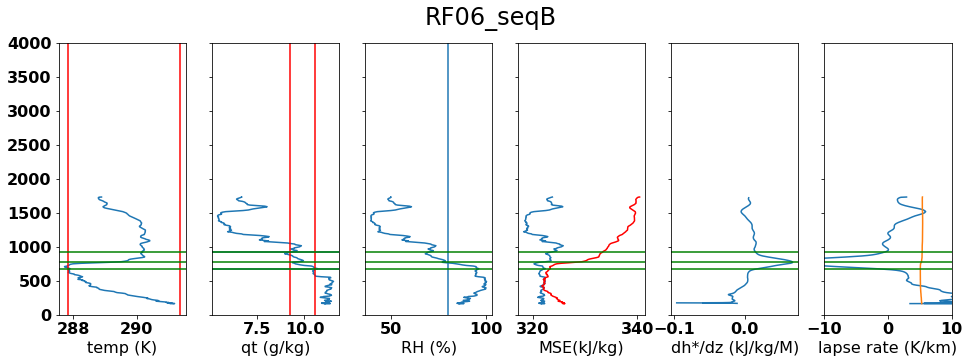

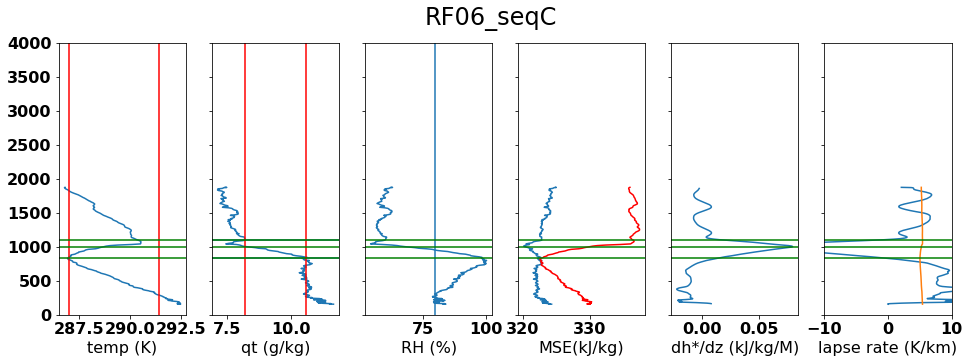

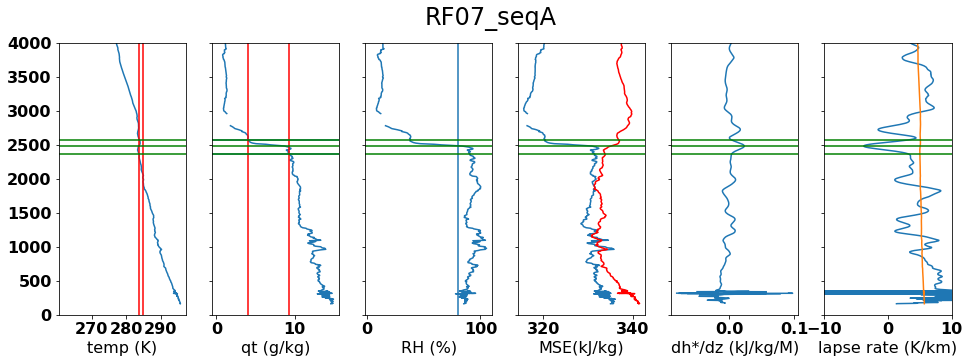

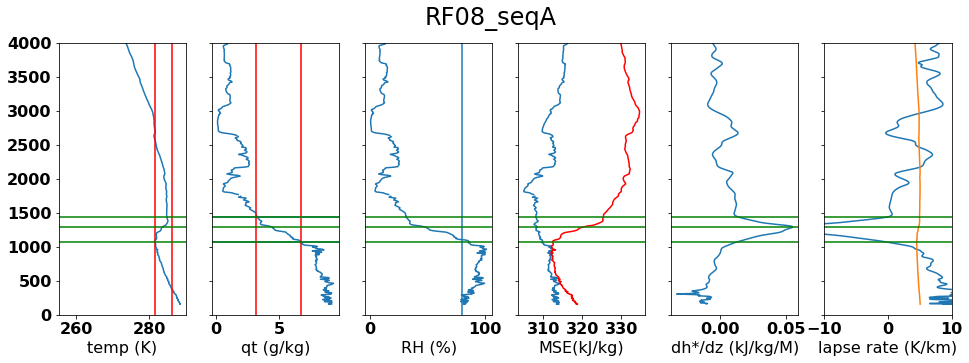

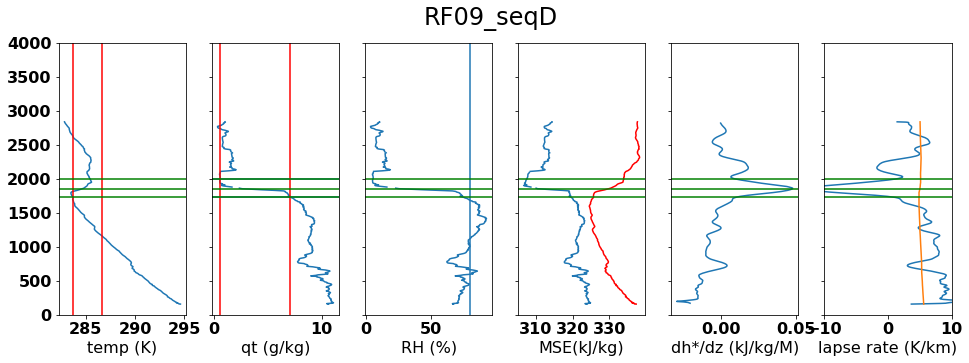

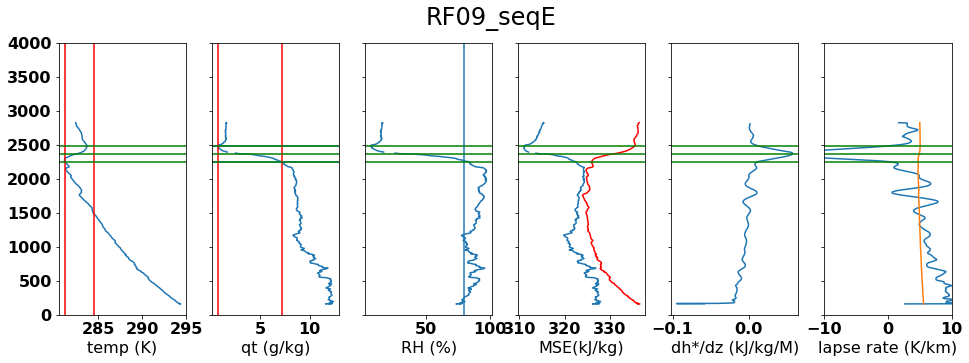

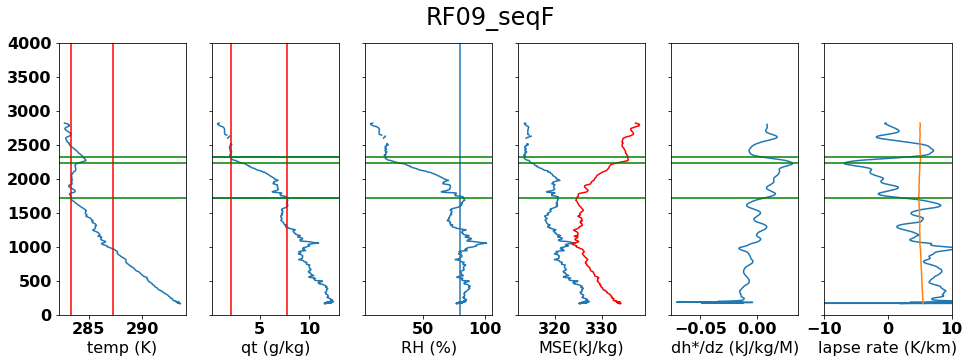

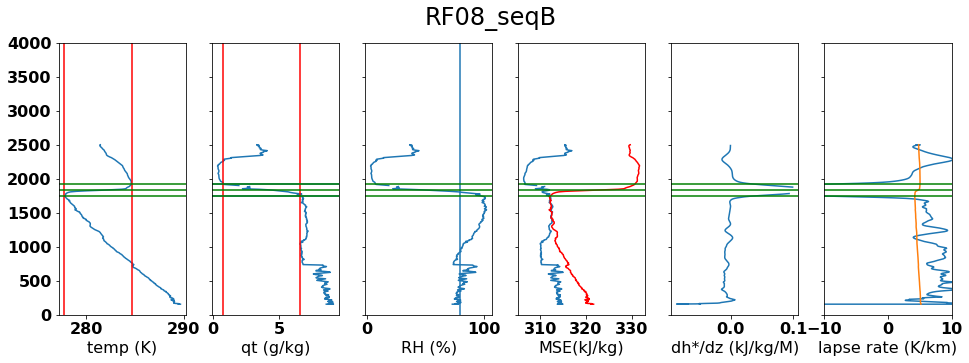

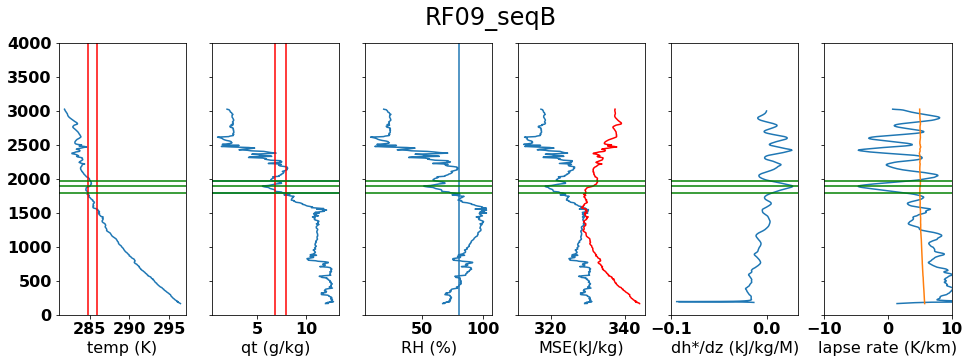

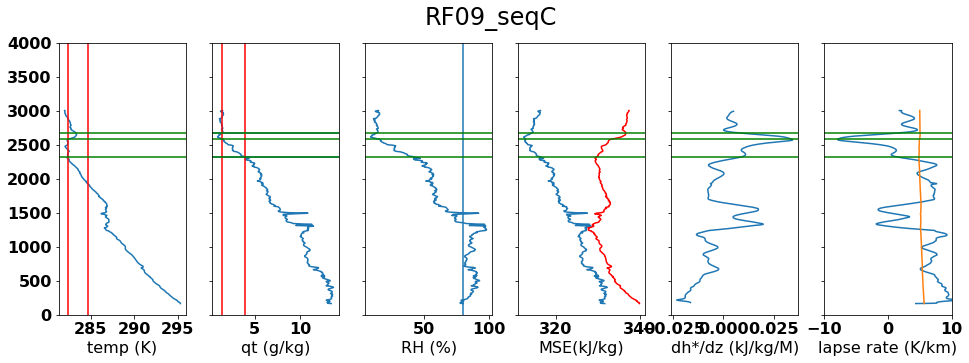

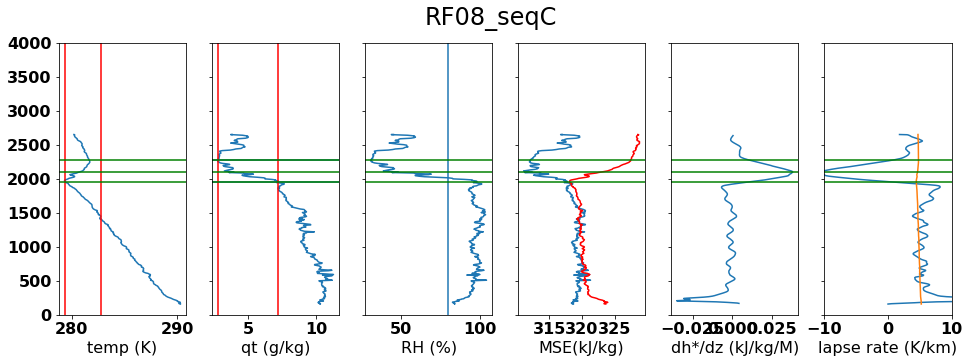

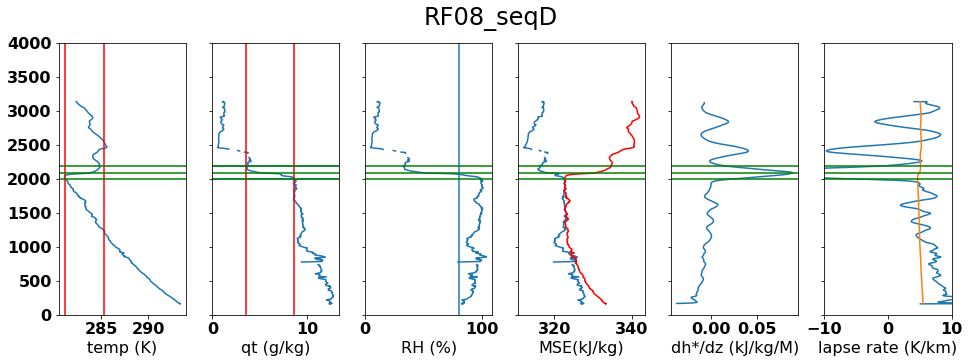

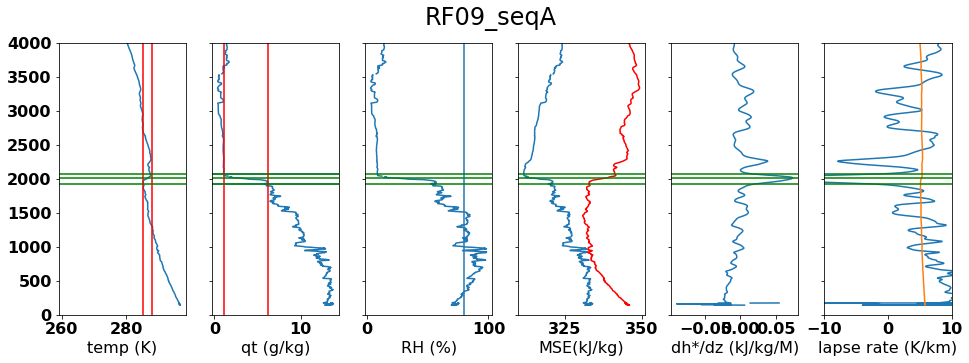

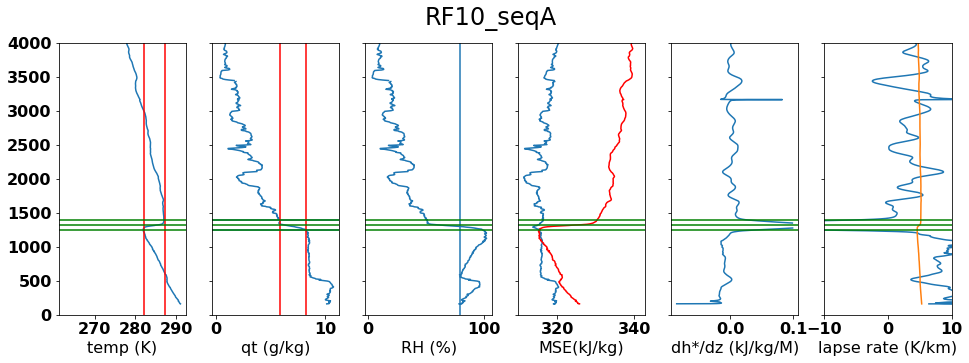

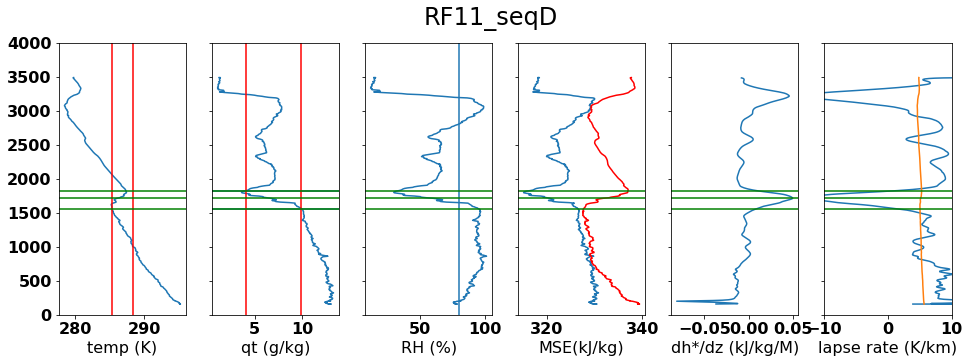

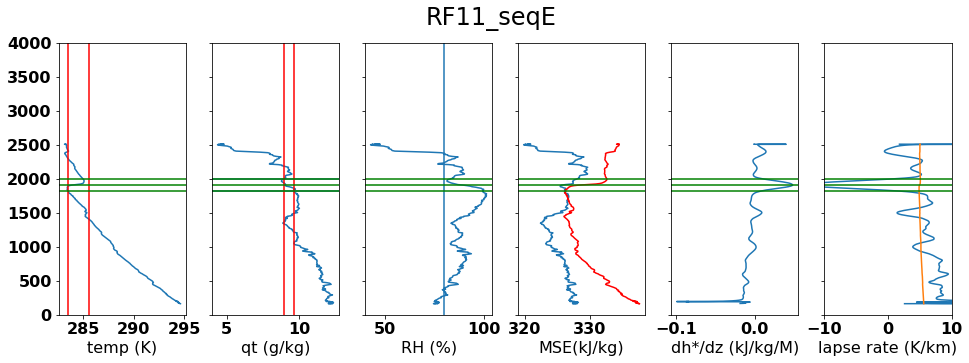

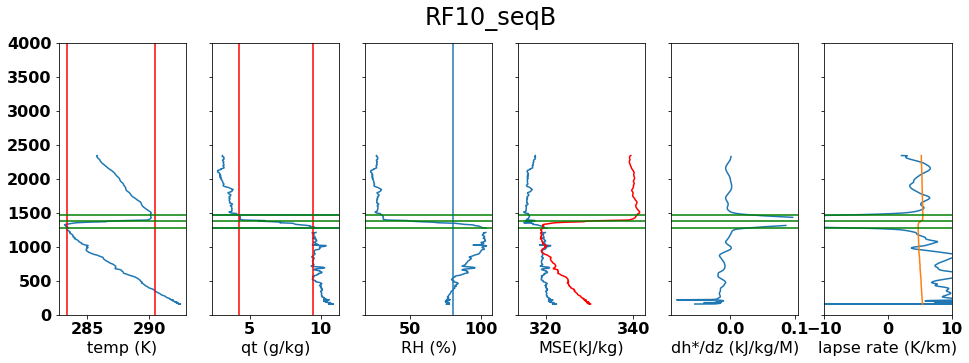

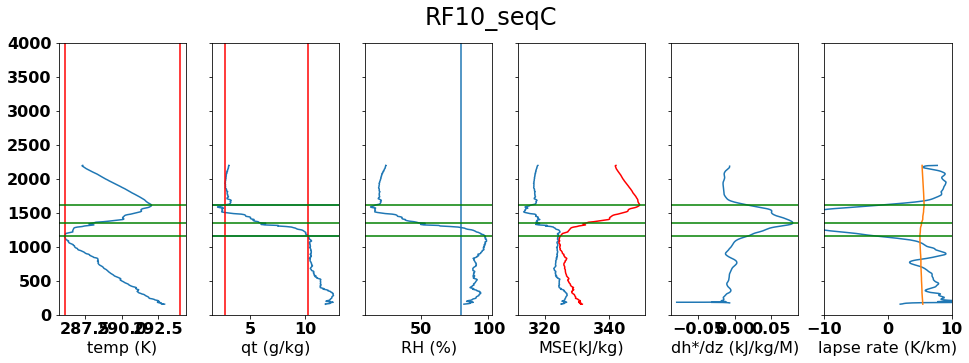

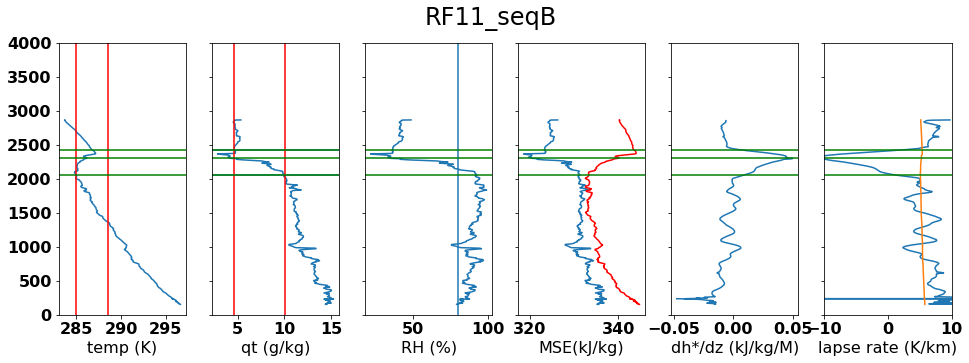

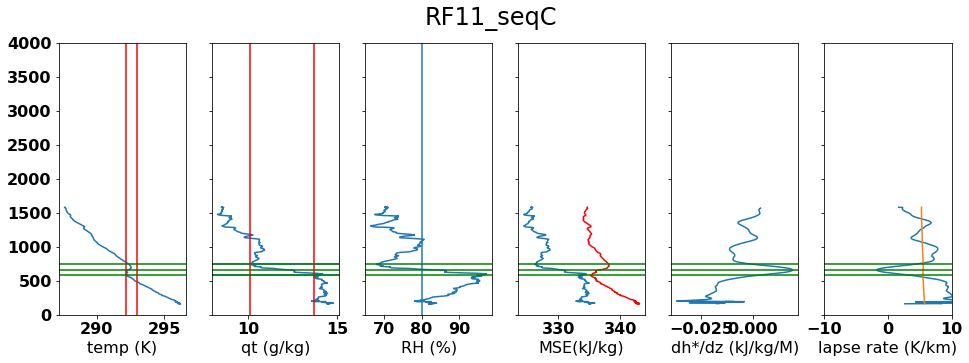

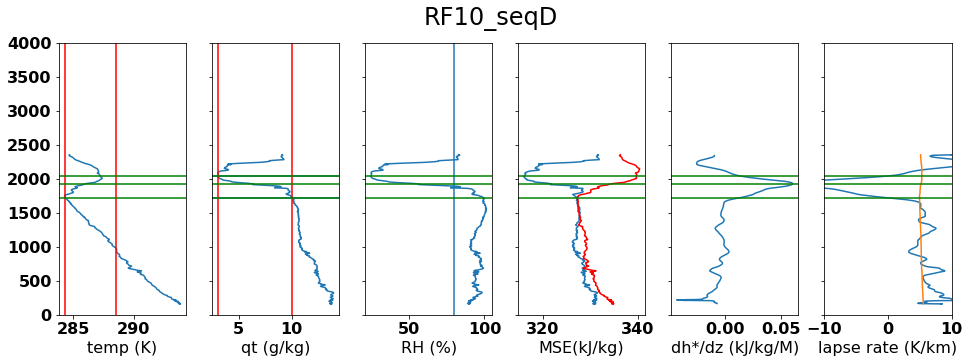

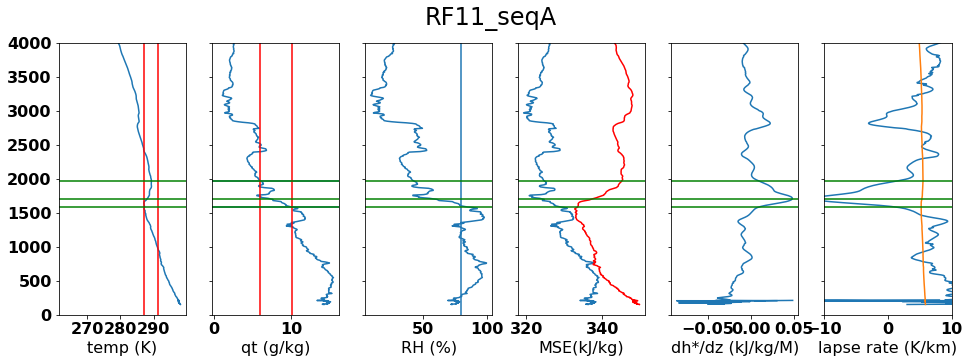

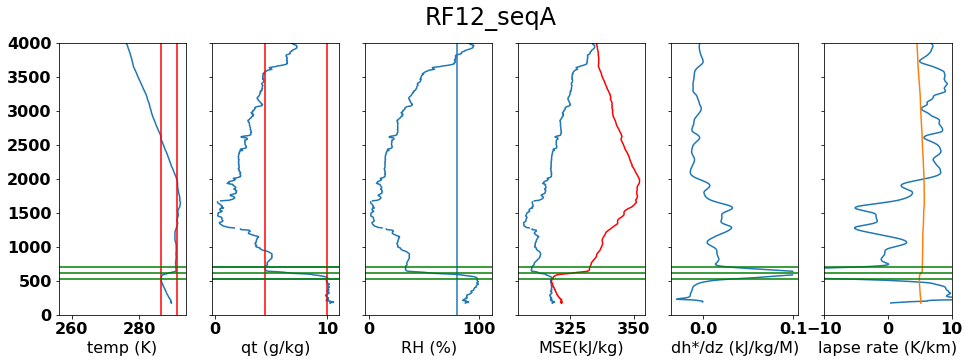

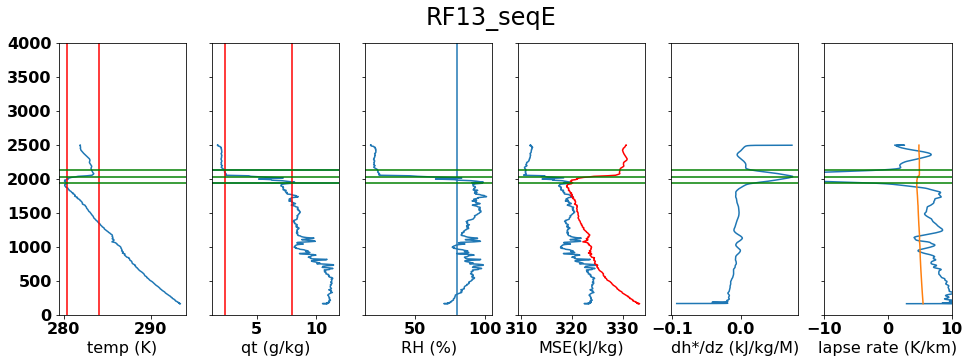

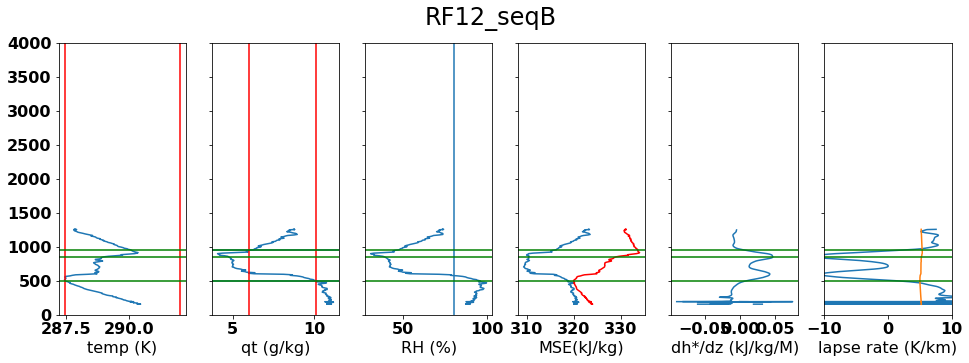

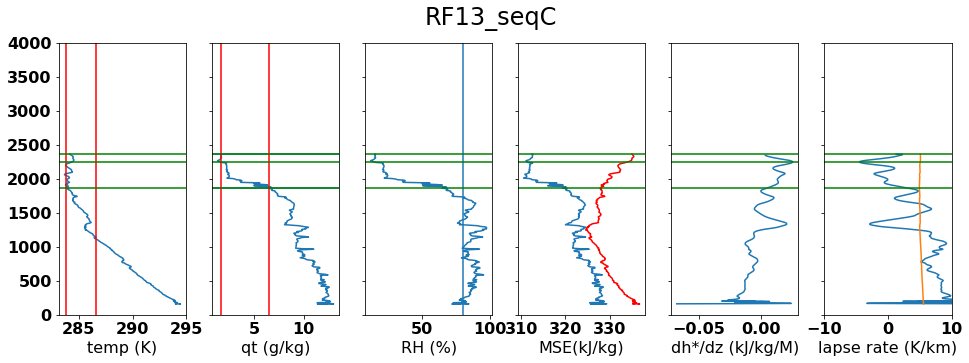

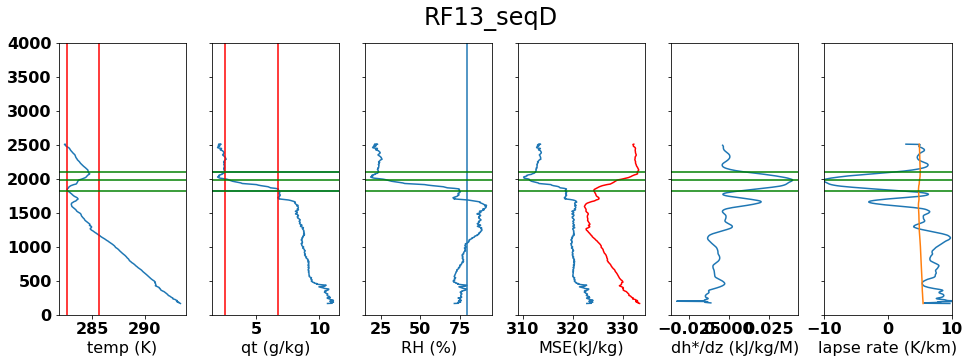

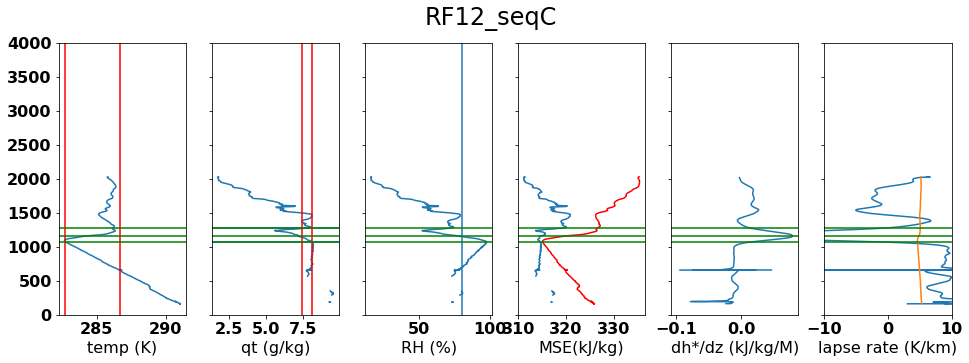

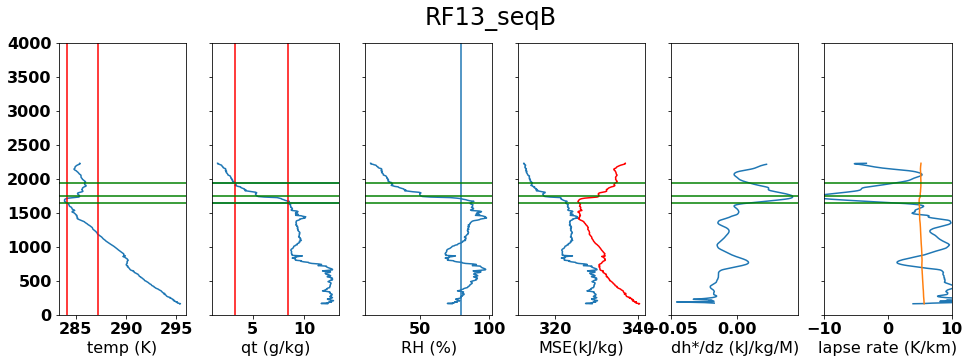

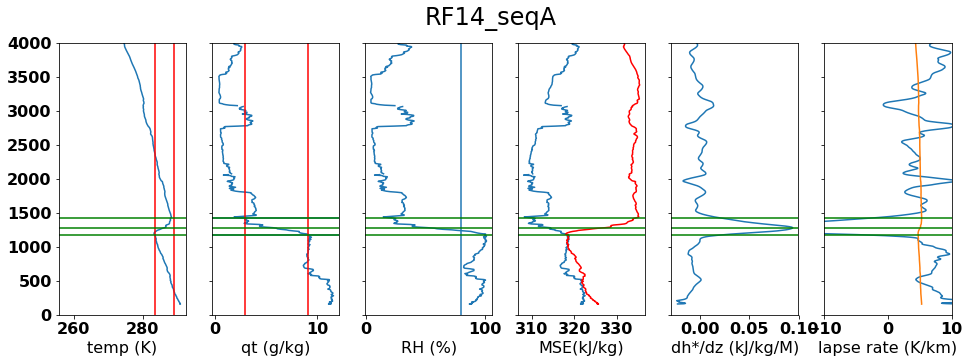

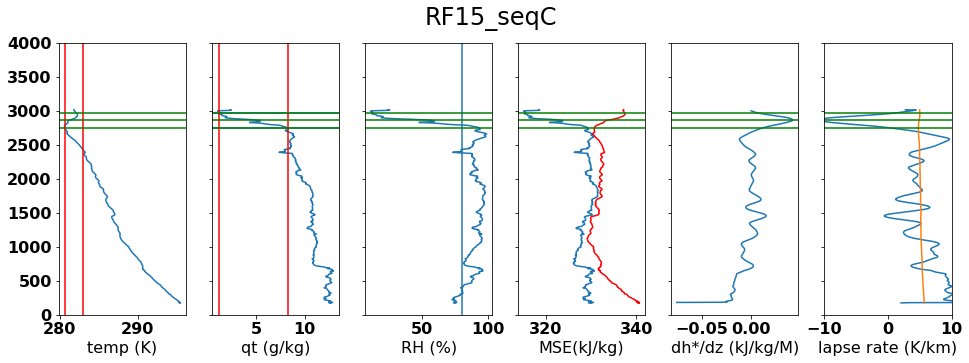

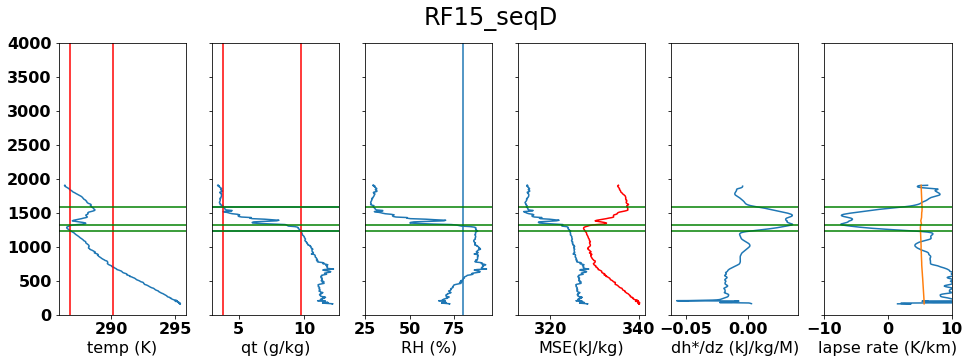

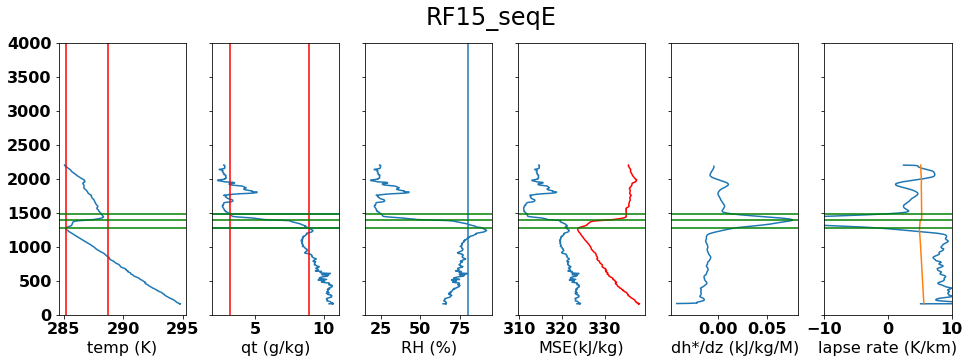

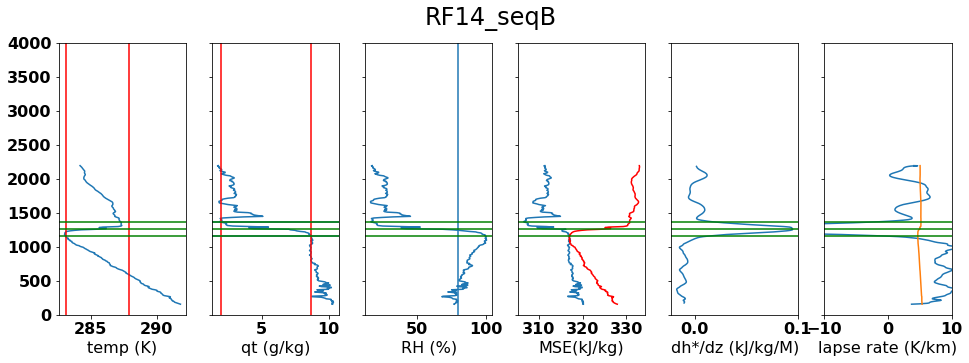

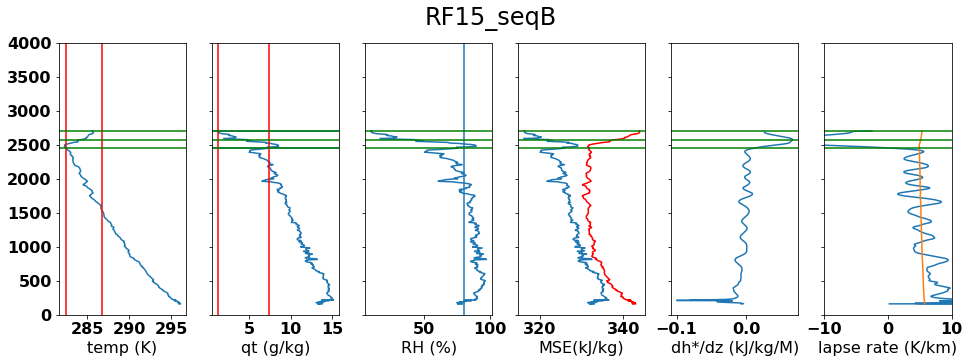

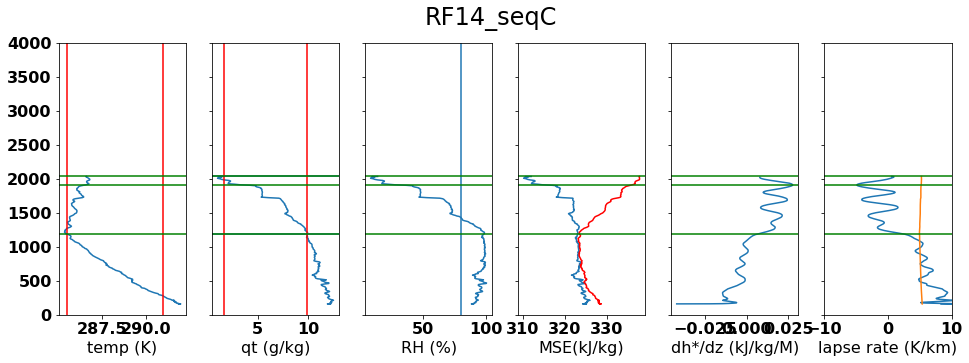

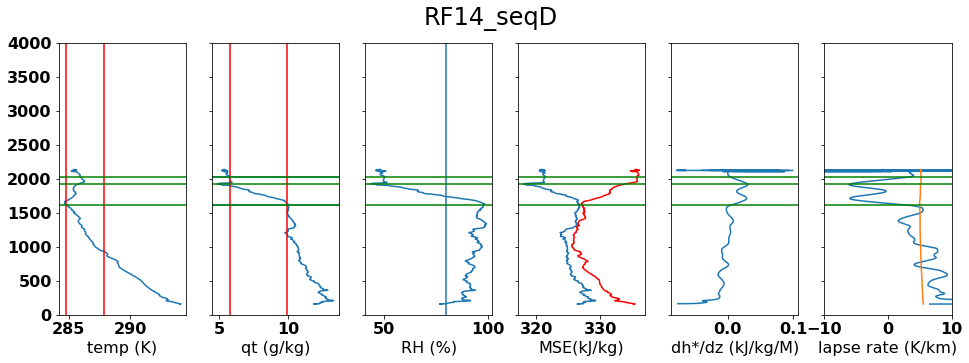

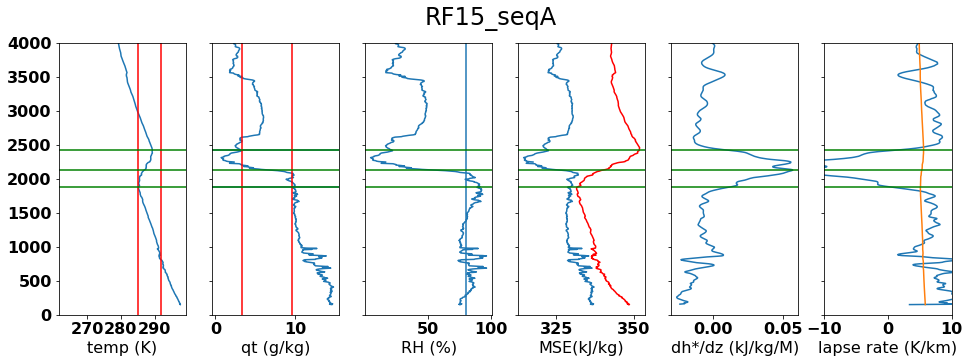

In [184]:
problem_cases = ['RF06_seqB', 'RF04_seqA', 'RF05_seqD', 'RF05_seqE', 'RF04_seqB', 'RF05_seqB', 'RF07_seqB', 'RF07_seqC', 'RF07_seqE', 'RF06_seqB', 'RF09_secB', 'RF09_seqC', 'RF110_seqE']


problem_cases = ['RF06_seqB', 'RF08_seqA']#, 'RF07_seqA', 'RF10_seqA', 'RF11_seqD', 'RF11_seqE']
i = 0
for num, case in ALC_cases.items():
    for fp in [case.outbound_Flight_Piece, case.return_Flight_Piece]:
        for seq in fp.sequences:
            name = "{}_seq{}".format(fp.flight_name, seq)
#             if name not in problem_cases:
#                 continue
#             print(name)
            profiles = fp.get_profiles(seqs = [seq])
            for seq, prof in profiles.items():
                name = "{}_seq{}".format(fp.flight_name, seq)
                plot_profile(prof, name)
                i+=1
                if i>10: 
                    break

In [ ]:
profile = prof.copy()
print(prof.keys())
z=profile['sounding']['ATX']
mse = mu.moist_static_energy(t=profile['sounding']['ATX'], z=z, q=profile['sounding']['QV'])
from met_utils import get_moist_adiabatic_lapse_rate, smooth

In [115]:
    
    zi = profile['zi']['Heff']
    dec = profile['dec']
    theta = profile['sounding']['THETA']
    z = profile['sounding']['GGALT']
    qv = profile['sounding']['QV']
    qt = qv + np.nan_to_num(profile['sounding']['QL'], 0)
    rh = profile['sounding']['RHUM']
    p = profile['sounding']['PSXC']
    t = profile['sounding']['ATX']
       
   
 
    gamma_moist = get_moist_adiabatic_lapse_rate(T=t, p=p)*1000
    gamma = -np.gradient(smooth(t, window_len=31), z)*1000
    gamma[np.gradient(z)>-1] = np.nan
    gamma[z<400] = np.nan
    gamma[z>3500] = np.nan
    gamma[np.abs(gamma)>100] = np.nan
    gamma_diff = (gamma-gamma_moist)/1000
    i_mid = np.nanargmin(gamma)
    z_mid = z[i_mid]
    
    
    z_bot = np.max(z[np.logical_and(z<z[i_mid], gamma>gamma_moist)])
    i_bot = np.argwhere(z==z_bot)
    
    top_candidates = np.logical_and(z>z[i_mid], gamma>gamma_moist)
    if np.any(top_candidates):
        z_top = np.min(z[top_candidates])
        i_top = np.argwhere(z==z_top)
    else: 
        cands = z>z[i_mid]
        if not np.any(cands):
            print(name)
            raise ValueError("no values above inversion middle!")

        z_top = z[cands][np.argmin(np.abs(gamma[cands]-gamma_moist[cands]))]
        i_top = np.argwhere(z==z_top)

    i_upper = np.logical_and(z<z_top, z>z_mid)
    if np.sum(i_upper) == 0:
        print("error: no upper inv later: z_top: {}  z_mid: {}".format(z_top, z_mid))
#         return buncha_nans
    i_lower = np.logical_and(z>z_bot, z<z_mid)
    
    q_above_inv = np.nanmin(qt[i_upper])
    q_below_inv = np.nanmax(qt[i_lower])
    d_q_inv = q_above_inv - q_below_inv

    
    
    t_below_inv = np.nanmin(t[i_lower])
    i_below_inv = np.argwhere(np.logical_and(t==t_below_inv, i_lower))[0][0]
    new_i_inv = np.logical_and(np.logical_and(z>z[i_below_inv], z<z_top), ~np.isnan(gamma_diff))
    
    
    d_t_inv = integrate.trapz(gamma_diff[new_i_inv], z[new_i_inv])
    t_above_inv = t_below_inv + d_t_inv

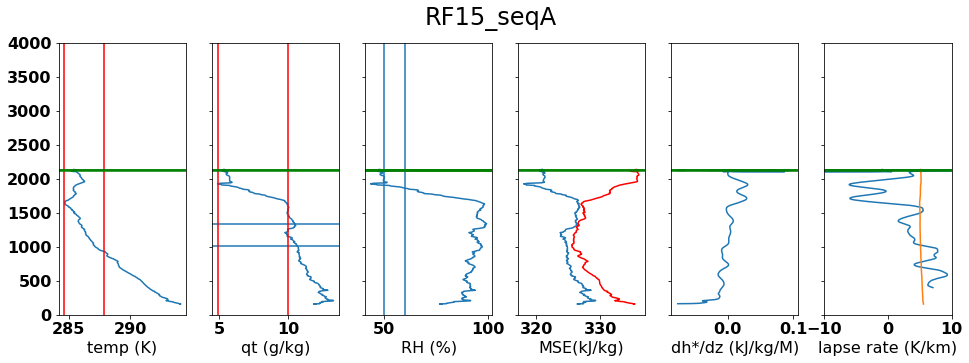

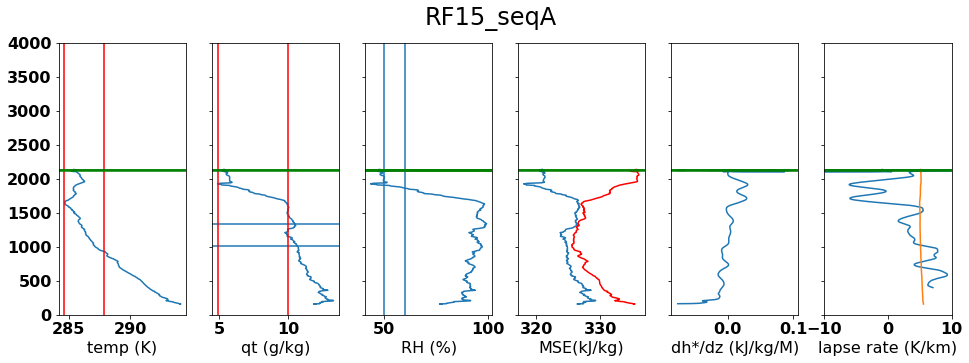

In [116]:
plot_profile(prof, name)

In [257]:
    gamma_moist = mu.get_moist_adiabatic_lapse_rate(T=t, p=p)*1000
    gamma = -np.gradient(mu.smooth(t, window_len=61), z)*1000
    gamma[z<350] = np.nan
    i_mid = np.nanargmin(gamma)
    
    i_bot = np.argwhere(z==np.max(z[np.logical_and(z<z[i_mid], gamma>gamma_moist)]))
    
    top_candidates = np.logical_and(z>z[i_mid], gamma>gamma_moist)
    if np.any(top_candidates):
        z_top = np.min(z[top_candidates])
        i_top = np.argwhere(z==z_top)
    else: 
        cands = z>z[i_mid]
        z_top = z[cands][np.argmin(np.abs(gamma[cands]-gamma_moist[cands]))]
        i_top = np.argwhere(z==z_top)

    
    plt.plot(gamma, z)
    plt.plot(gamma_moist, z)
    plt.gcf().set_size_inches(5,3)
    plt.axhline(z[i_mid], c='r')
    plt.axhline(z[i_bot], c='r')
    plt.axhline(z[i_top], c='r')

ValueError: attempt to get argmin of an empty sequence

In [185]:
def plot_profile2(profile, name, lims=(0,4000), ax=None):
    
    zi = profile['dec']
    dec = profile['dec']
    theta = profile['sounding']['THETA']
    z = profile['sounding']['GGALT']
    qv = profile['sounding']['QV']
    qt = qv + np.nan_to_num(profile['sounding']['QL'], 0)
    rh = profile['sounding']['RHUM']
    p = profile['sounding']['PSXC']
    t = profile['sounding']['ATX']
    
    gamma_moist = mu.get_moist_adiabatic_lapse_rate(T=t, p=p)*1000
    gamma = -np.gradient(mu.smooth(t, window_len=31), z)*1000
 
    if ax is None:
        fig, [ax1, ax2, ax3, ax6] = plt.subplots(ncols=4, sharey=True, figsize=(8,3))
    else:
        ax1, ax2, ax3, ax6 = ax
        fig = plt.gcf()
    ax1.plot(t, z)
    ax1.set_ylim(lims)
    ax1.set_xticks(np.arange(0, 300, 3))
    ax1.set_xlim(dec['t_below_inv']-1, dec['t_above_inv']+1.5)
    
    ax1.set_xlabel('$temp$ (K)')
    ax1.axvline(dec['t_below_inv'], label='t_below_inv', c='r')
    ax1.axvline(dec['t_above_inv'], label='t_above_inv', c='r')

    d_t = dec['d_t_inv']
    d_thetae = theta[dec['i_top']] - theta[dec['i_bot']]    

    ax2.plot(qt, z)
    lims = ax2.get_xlim()
    ax2.set_xticks(np.arange(0, 15, 2))
    ax2.set_xlim(lims)
    ax2.axhline(zi['z_bot'], label='inv base')
    ax2.axhline(zi['z_top'], label='inv top')
    ax2.set_xlabel("$q_t$ (g kg$^{-1}$)")
    ax2.axvline(dec['q_below_inv'], label='q_below_inv', c='r')
    ax2.axvline(dec['q_above_inv'], label='q_above_inv', c='r')
    
    
    ax3.plot(rh, z)
    ax3.set_xlabel('RH (%)')
    ax3.axvline(50)
    
    ax3.set_xlim(0,100)

    ax6.plot(gamma, z, label='$\Gamma$')
    ax6.plot(gamma_moist, z, label='$\Gamma_m$')
    ax6.set_xlabel('lapse rate (K km$^{-1}$)')
    
    ax6.set_xlim(gamma[zi['i_mid']], 10)
    ax6.legend(prop={'size': 10}, loc='lower left')
    
    if not np.isnan(dec['i_mid']):   
        for ax in [ax1, ax2, ax3, ax6]:#, ax4, ax5, ax6]:
            ax.axhline(z[dec['i_mid']], c='g')
            ax.axhline(z[dec['i_bot']], c='g')
            ax.axhline(z[dec['i_top']], c='g')
    
    else:
        ax3.text(0.2, 0.8, 'NO INV')

    
    
#     fig.suptitle(name, fontsize=14)
#     ax1.annotate('{}'.format(name), xy=(0.05, 0.85), xycoords='axes fraction', backgroundcolor='white', fontsize=12)

    return fig

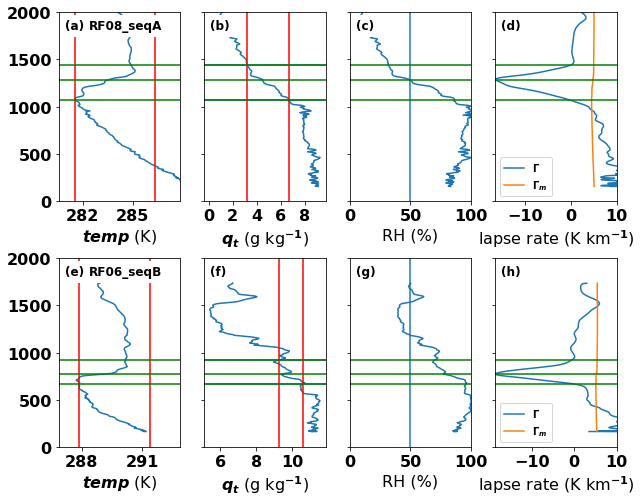

In [186]:
problem_cases = ['RF06_seqB', 'RF06_seqC', ]#'RF07_seqA', 'RF10_seqA', 'RF11_seqD', 'RF11_seqE']
i = 0
#"RF07_seqE": (0,2500), , "RF07_seqA": (1000,3000)}
lim_map = {"RF06_seqB": (0,1500), "RF08_seqA": (0, 2000)}
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=4, figsize=(10,8), sharey=True)
ax_list = [ax1, ax2]

for num, case in ALC_cases.items():
#     if num not in [6]:
#         continue
    for fp in [case.outbound_Flight_Piece, case.return_Flight_Piece]:
        for seq in fp.sequences:
            name = "{}_seq{}".format(fp.flight_name, seq)
            if name not in lim_map.keys():
                continue
#             print(name)
            profiles = fp.get_profiles(seqs = [seq])
            for seq, prof in profiles.items():
                name = "{}_seq{}".format(fp.flight_name, seq)
                if name in lim_map.keys():
                    lims = lim_map[name]
                else:
                    lims = (0,4000)
                ax = ax_list.pop()
                plot_profile2(prof, name, lims=lims, ax=ax)
                ax[0].annotate('{}'.format(name), xy=(0.25, 0.91), xycoords='axes fraction', backgroundcolor='white', fontsize=12)
                i+=1
                if i>10: 
                    break
                    
plt.subplots_adjust(hspace=0.3)
s = 'abcdefgh'
for i, c in enumerate(list(ax1)+list(ax2)):
    c.annotate('({})'.format(s[i]), xy=(0.05, 0.91), xycoords='axes fraction', backgroundcolor='white', fontsize=12)
fig.savefig(os.path.join(utils.plot_dir, "AP1_sample_profiles.png"), dpi=600, bbox_inches='tight')
